# Multi-step naive forecasting

In the previous section, we forecasted one step ahead: we forecasted the pollutant concentration for the next hour. 

Very often, we want to forecast more than one step ahead. For example, we want to forecast the pollutant concentration **every hour over the next 24 hours**.

In this notebook, we will examine one procedure for **multi-step forecasting**. We will make a naive forecast, predicting the future value based on the past value of the pollutant concentration. This way, we will become familiar with the procedure and the challenges, in particular those relevant to this data. In the following notebooks, we will extend this to multi-step forecasting utilizing linear regression.

**For simplicity, we will only forecast the concentration of carbon monoxide (CO).**


## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load Data

In [2]:
# If you followed the instructions to download the data,
# it should be located here:

filename = "../datasets/AirQualityUCI_ready.csv"

# Load data: only the time variable and CO
# Passing the `Date_Time` column to the parse_dates argument
# will mean that pandas converts the type of the column to a
# datetime on loading the data.
data = pd.read_csv(
    filename,
    usecols=["Date_Time", "CO_sensor"],
    parse_dates=["Date_Time"],
    index_col=["Date_Time"],
)

print(data.shape)

data.head()

(9357, 1)


,CO_sensor
Date_Time,
2004-10-03 18:00:00,1360.0
2004-10-03 19:00:00,1292.0
2004-10-03 20:00:00,1402.0
2004-10-03 21:00:00,1376.0
2004-10-03 22:00:00,1272.0


In [3]:
# Sanity: sort index.

data.sort_index(inplace=True)

## Reduce data span

I will narrow down the dataset to those portions with fewer timestamps missing.

We discussed this in section 2.

In [4]:
# Remove data with a lot of missing information.

# Check our notebook in section 2 to understand
# why we perform this step

data = data[(data.index >= "2004-04-01") & (data.index <= "2005-04-30")]

# Quick check: data span.

print(data.index.min(), data.index.max())

2004-04-04 00:00:00 2005-04-04 14:00:00


## Remove Outliers

Outliers are the negative values returned by the sensors.

We discussed this in section 2.

In [5]:
print(data.shape)

# remove negative observations
data = data.loc[(data["CO_sensor"] > 0)]

print(data.shape)

(7677, 1)
(7393, 1)


In [6]:
# The data, ready to use.

data.head()

,CO_sensor
Date_Time,
2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,1028.0


# Split data into train and test

We "train" the model on a training set and evaluate its performance on a test set. This is good practice to avoid leaking information to the model and to conduct a fair evaluation on a completely new dataset.

I wrote "train" between inverted commas because, in this case, our model does not really learn any parameters from the data. But we want to evaluate our benchmark model under the same conditions as we would our real model, in the coming notebooks.

In [7]:
# Split the data: we leave the last month
# for evaluation.

X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= "2005-03-04"]

# Naive Forecast

We will predict the pollutant's concentration at time *t* with its value at time *t-1*. 

This is our benchmark model.

In [8]:
# This is a simple class: it takes in the dataframe
# with the target variable and returns the naive
# forecast predictions, which is the pollutant's
# concentration for the previous hour.


class NaiveForecast:
    def __init__(self, lag, target):

        # To start the forecaster we need
        # to pass the name of the target variable
        # and the lag value to use as forecast

        self.lag = lag
        self.target = target

    def predict(self, X):

        # We predict the target with its lag value

        pred = X[self.target].shift(freq=self.lag)

        return pred

In [9]:
# Set up the naive forecast

naive = NaiveForecast(lag="1H", target="CO_sensor")

In [10]:
# Make predictions.

# We can use it like any Scikit-learn
# estimator.


preds = naive.predict(X_train)

preds

Date_Time
2004-04-04 01:00:00    1224.0
2004-04-04 02:00:00    1215.0
2004-04-04 03:00:00    1115.0
2004-04-04 04:00:00    1124.0
2004-04-04 05:00:00    1028.0
                        ...  
2005-03-03 20:00:00    1473.0
2005-03-03 21:00:00    1396.0
2005-03-03 22:00:00    1285.0
2005-03-03 23:00:00    1206.0
2005-03-04 00:00:00    1179.0
Name: CO_sensor, Length: 6850, dtype: float64

The last prediction is already one step ahead of the data we have in the train set. This becomes clearer in the next cell.

In [11]:
# Let's concatenate our predictions with
# our training data.

pd.concat([X_train, preds], axis=1)

,CO_sensor,CO_sensor
Date_Time,,
2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,1215.0,1224.0
2004-04-04 02:00:00,1115.0,1215.0
2004-04-04 03:00:00,1124.0,1115.0
2004-04-04 04:00:00,1028.0,1124.0
...,...,...
2005-03-03 20:00:00,1396.0,1473.0
2005-03-03 21:00:00,1285.0,1396.0
2005-03-03 22:00:00,1206.0,1285.0


The Naive Forecaster, already predicts one step ahead of the data that we have: note the last row in the dataframe.

## Capture the first hour prediction.

To carry out multi-step forecasting, we make the prediction for the next hour, and then that value becomes a new feature that we can use to predict the concentration in the second hour, and so on.

In [12]:
# The pollutant concentration
# in the first hr.

preds.iloc[-1]

1179.0

In [13]:
# Create the timestamp of the next hr that we want to predict

[X_train.index[-1] + pd.offsets.Hour(1)]

[Timestamp('2005-03-04 00:00:00')]

In [14]:
# Put pollutant and timestamp in a mini dataframe

step = {
    "CO_sensor": [preds.iloc[-1]],
    "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(1)],
}

step = pd.DataFrame(step)
step.set_index("Date_Time", inplace=True)

step

,CO_sensor
Date_Time,
2005-03-04,1179.0


To make a multi-step forecast, we use the prediction as a new value, and make a further prediction using this value.

Thus, we append our prediction to the train set, to make a new prediction, now 2 steps ahead.

In [15]:
# Append the first prediction
# to the train set.

X_train = X_train.append(
    step, ignore_index=False, verify_integrity=True, sort=True  # the prediction
)

X_train.tail(3)

,CO_sensor
Date_Time,
2005-03-03 22:00:00,1206.0
2005-03-03 23:00:00,1179.0
2005-03-04 00:00:00,1179.0


We see our prediction in the train set. It shows the same value as the former prediction, because, well, we are making a naive forecast.

In [16]:
# We make predictions again.

preds = naive.predict(X_train)

preds

Date_Time
2004-04-04 01:00:00    1224.0
2004-04-04 02:00:00    1215.0
2004-04-04 03:00:00    1115.0
2004-04-04 04:00:00    1124.0
2004-04-04 05:00:00    1028.0
                        ...  
2005-03-03 21:00:00    1396.0
2005-03-03 22:00:00    1285.0
2005-03-03 23:00:00    1206.0
2005-03-04 00:00:00    1179.0
2005-03-04 01:00:00    1179.0
Name: CO_sensor, Length: 6851, dtype: float64

And now, we have two steps ahead of our data.

Because this is a naive forecast and we always predict the last value, it is clear that the multi-step forecast, will always show the same value. It will be a constant prediction.

## Forecasting 24 steps ahead.

Let's now go ahead and predict the next 24 hours of pollutant concentration.

We start by calculating the first hour concentration as we did previously, appending the value to the train set, and repeating this process 24 times.

In [17]:
# Split the data

X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= "2005-03-04"]

In [18]:
# We repeat the process 24 times:

# That is, we predict one hr. ahead,
# append the value to the train set,
# and predict the second value ahead,
# append the new prediction to the train set
# and continue, until we predict 24 hrs. ahead.

for i in range(24):

    # Make predictions on the train set.
    preds = naive.predict(X_train)

    # Capture first prediction with correct timestamp in a mini df.
    step = {
        "CO_sensor": [preds.iloc[-1]],
        "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(1)],
    }
    step = pd.DataFrame(step)
    step.set_index("Date_Time", inplace=True)

    # Append the last prediction to the train
    # set.
    X_train = X_train.append(step, ignore_index=False, verify_integrity=True, sort=True)

In [19]:
# After the previous loop, we now have
# our 24 predictions at the end of the
# train set.

X_train.tail(24)

,CO_sensor
Date_Time,
2005-03-04 00:00:00,1179.0
2005-03-04 01:00:00,1179.0
2005-03-04 02:00:00,1179.0
2005-03-04 03:00:00,1179.0
2005-03-04 04:00:00,1179.0
2005-03-04 05:00:00,1179.0
2005-03-04 06:00:00,1179.0
2005-03-04 07:00:00,1179.0
2005-03-04 08:00:00,1179.0


<AxesSubplot:xlabel='Date_Time'>

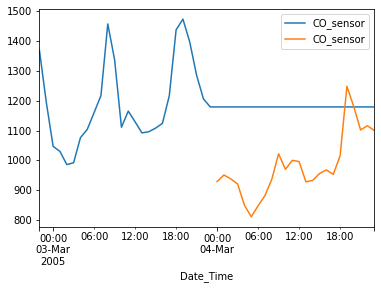

In [20]:
# We can plot our predictions vs. the truth, which is
# the CO concentration in the test set.

tmp = pd.concat([X_train.tail(50), X_test.head(24)], axis=1)
tmp["CO_sensor"].plot()

We see that the predictions were not great. This was to be expected, because, well, we are making a naive forecast.

In [21]:
# And now we calculate the RMSE for the 24 hr.
# chunk.

print(
    "rmse: ",
    mean_squared_error(
        y_true=X_test["CO_sensor"].head(24),
        y_pred=X_train["CO_sensor"].tail(24),
        squared=False,
    ),
)

rmse:  222.68372564394252


# Back-testing with expanding window.

Now, we will make predictions with an expanding window. We will "train" the model up to a certain point, and then make predictions 24hs ahead. We will then "train" the model up to a point further in the future, and make predictions 24hs ahead. And so on.



<img src='../images/backtesting.png' width="600" height="600">


In [22]:
# Capture first day on test set

start = X_test.index.min()
start

Timestamp('2005-03-04 00:00:00')

In [23]:
# Capture last day on test set

end = X_test.index.max()
end

Timestamp('2005-04-04 14:00:00')

In [24]:
# Create a 24 hr date range.

pd.date_range(start=start, end=end, freq="24H")

DatetimeIndex(['2005-03-04', '2005-03-05', '2005-03-06', '2005-03-07',
               '2005-03-08', '2005-03-09', '2005-03-10', '2005-03-11',
               '2005-03-12', '2005-03-13', '2005-03-14', '2005-03-15',
               '2005-03-16', '2005-03-17', '2005-03-18', '2005-03-19',
               '2005-03-20', '2005-03-21', '2005-03-22', '2005-03-23',
               '2005-03-24', '2005-03-25', '2005-03-26', '2005-03-27',
               '2005-03-28', '2005-03-29', '2005-03-30', '2005-03-31',
               '2005-04-01', '2005-04-02', '2005-04-03', '2005-04-04'],
              dtype='datetime64[ns]', freq='24H')

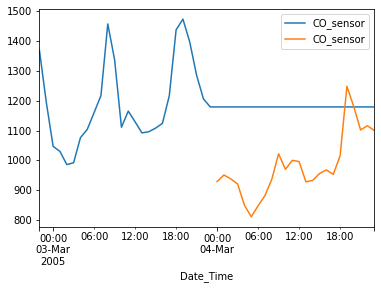

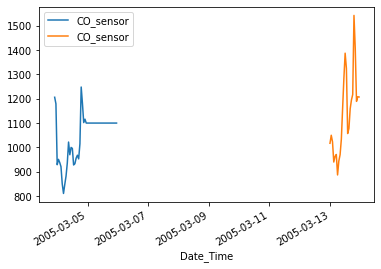

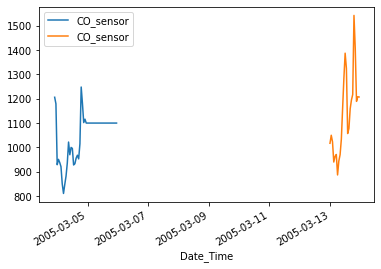

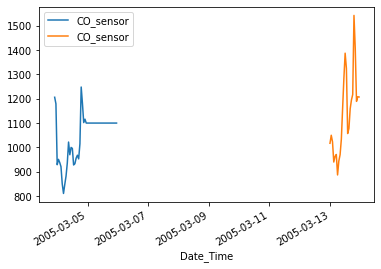

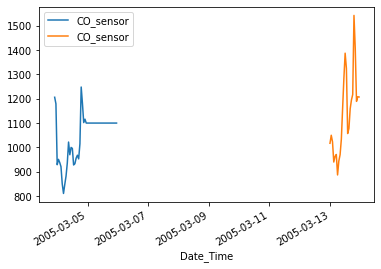

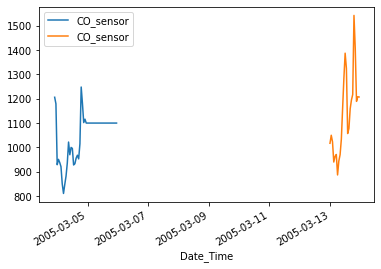

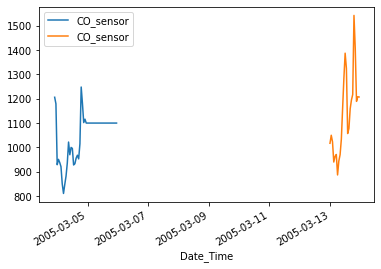

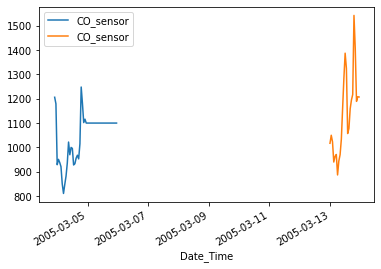

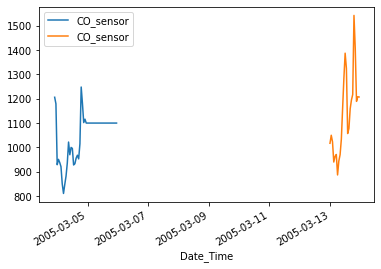

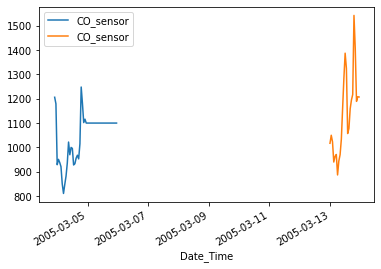

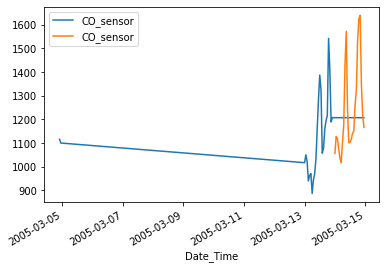

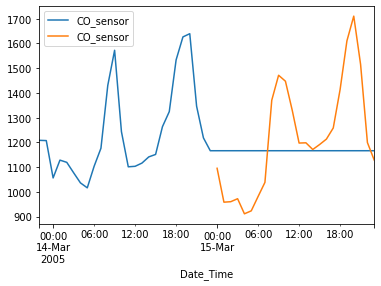

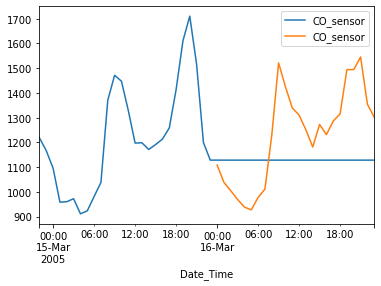

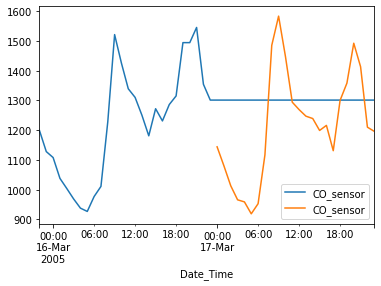

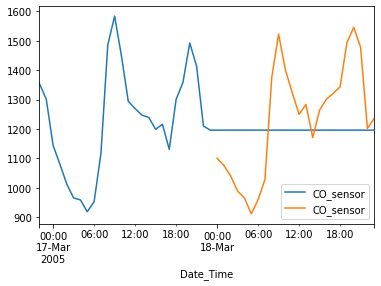

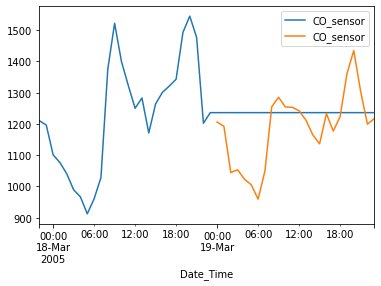

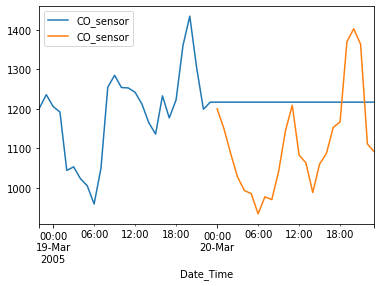

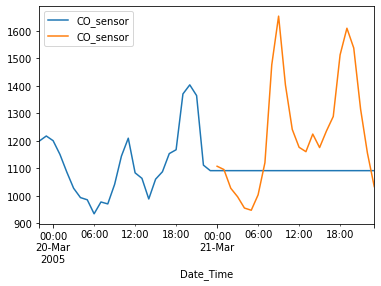

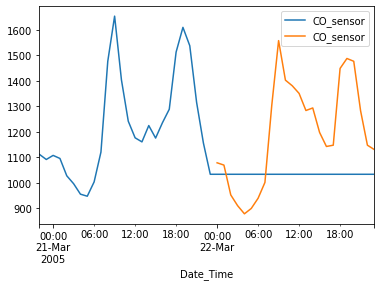

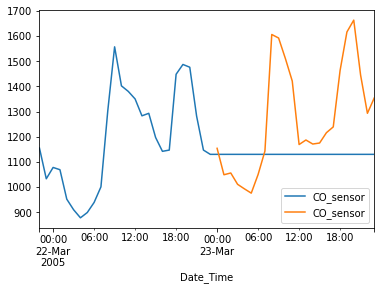

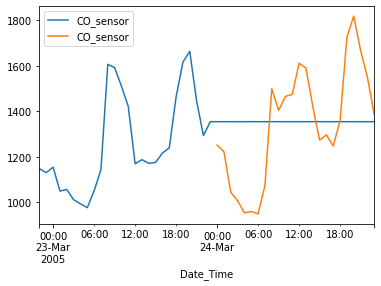

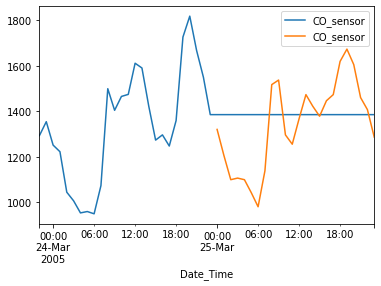

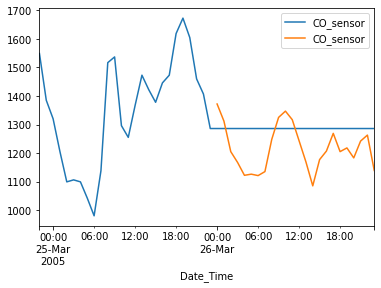

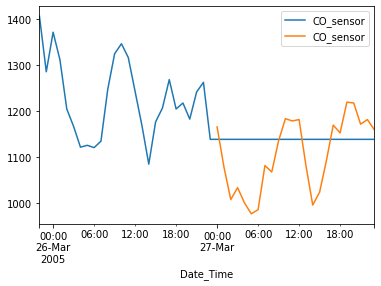

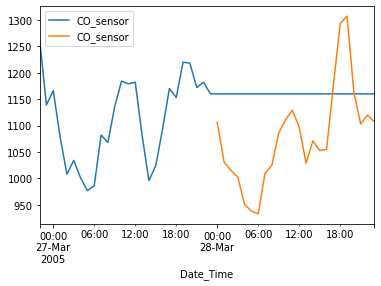

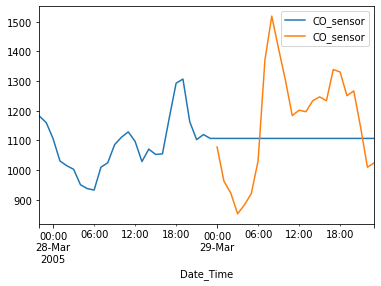

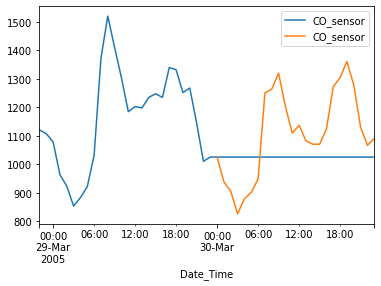

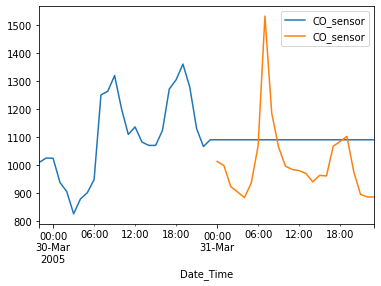

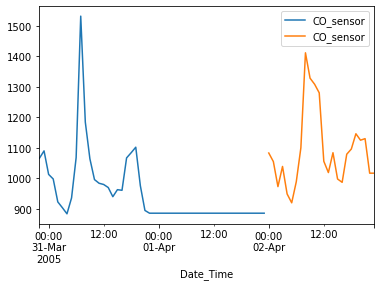

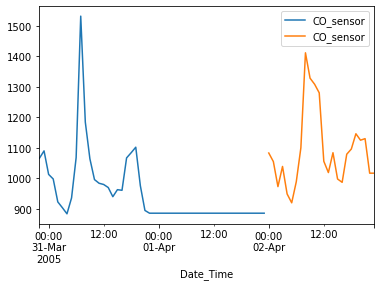

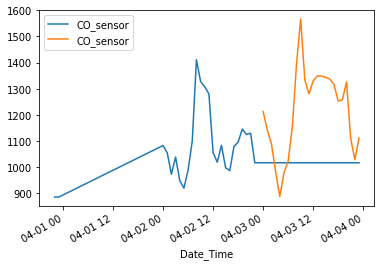

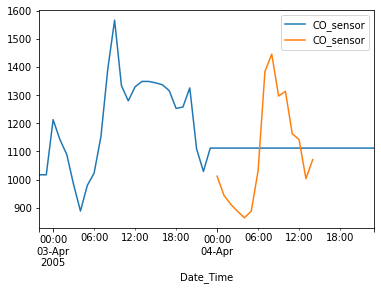

In [25]:
# Now we loop, expanding the train set 24 hr.
# on each round.

for date in pd.date_range(start=start, end=end, freq="24H"):

    # Split the data:
    # Here we perform the expanding window.
    X_train = data[data.index < date]

    # We only select the next 24 hrs of real
    # Pollutant concentration to test against
    X_test = data[data.index >= date].head(24)

    # Multi-step forecast:
    for i in range(24):

        # make predictions on the train set
        preds = naive.predict(X_train)

        # Capture first prediction with correct timestamp in a mini df.
        step = {
            "CO_sensor": [preds.iloc[-1]],
            "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(1)],
        }
        step = pd.DataFrame(step)
        step.set_index("Date_Time", inplace=True)

        # Append the last prediction to the train
        # set.
        X_train = X_train.append(
            step, ignore_index=False, verify_integrity=True, sort=True
        )

    # Plot the predictions for every 24hs chunk
    tmp = pd.concat([X_train.tail(50), X_test], axis=1)
    tmp["CO_sensor"].plot()
    plt.show()

In [26]:
# We repeat the process 24 times:

# That is, we predict one hr. ahead,
# append the value to the train set,
# and predict the second value ahead,
# append the new prediction to the train set
# and continue, until we predict 24 hrs. ahead.

for i in range(24):

    # Make predictions on the train set.
    preds = naive.predict(X_train)

    # Capture first prediction with correct timestamp in a mini df.
    step = {
        "CO_sensor": [preds.iloc[-1]],
        "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(1)],
    }
    step = pd.DataFrame(step)
    step.set_index("Date_Time", inplace=True)

    # Append the last prediction to the train
    # set.
    X_train = X_train.append(step, ignore_index=False, verify_integrity=True, sort=True)

If you went over section 2, you would not be surprised to find that some plots are broken. This is because we have a lot of missing timestamps both in the train and the test set.

To evaluate the model, we need to have the pollutant concentration values for the whole day in the test set.

So in the next cell, we will optimize the loop to evaluate only those pieces of data in the portions of the test set where we do have pollutant concentration for the entire day.

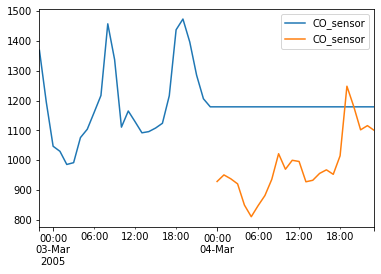

rmse:  222.68372564394252


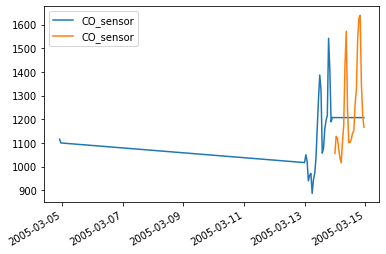

rmse:  189.26051269788599


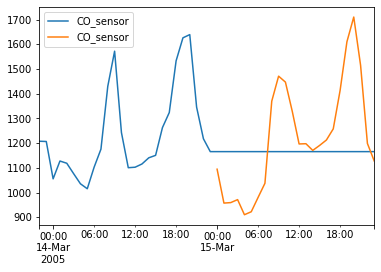

rmse:  226.84006847703662


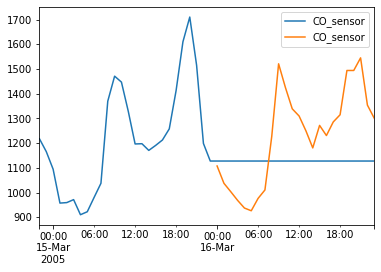

rmse:  216.43205246296893


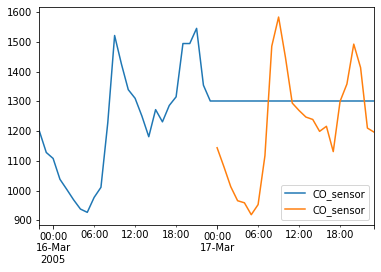

rmse:  198.68725424646644


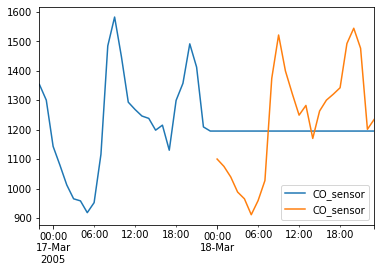

rmse:  189.15910410727437


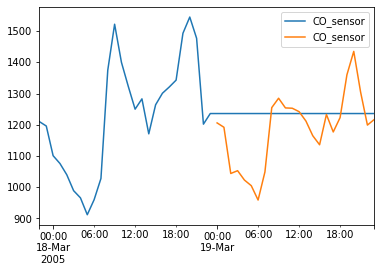

rmse:  123.78947181942951


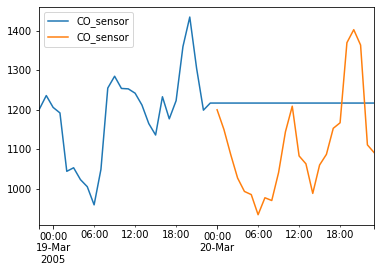

rmse:  164.07442416984637


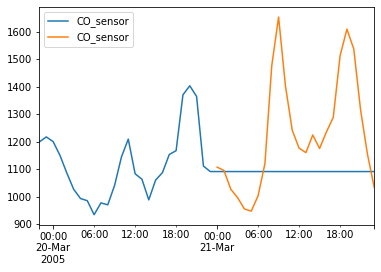

rmse:  245.247833833451


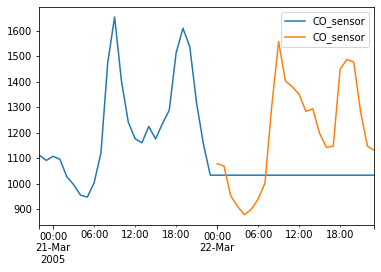

rmse:  259.9884612824192


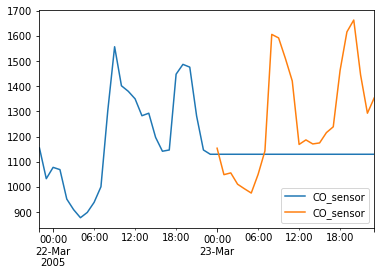

rmse:  256.5659434401482


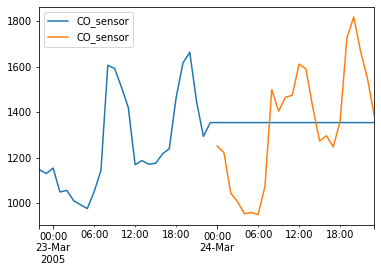

rmse:  249.47428057149833


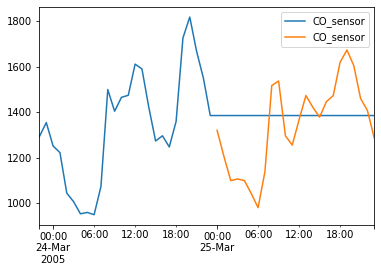

rmse:  194.6204639805383


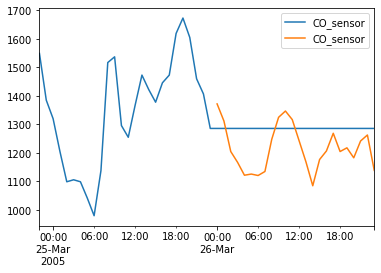

rmse:  103.91923947630359


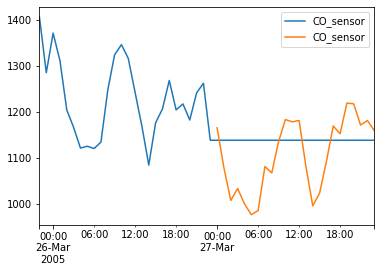

rmse:  84.49901380095115


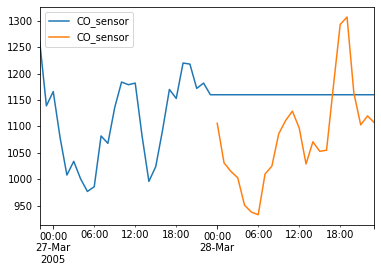

rmse:  122.13960591607186


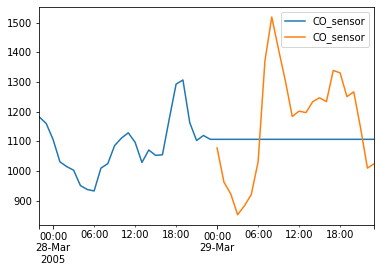

rmse:  185.11055255351238


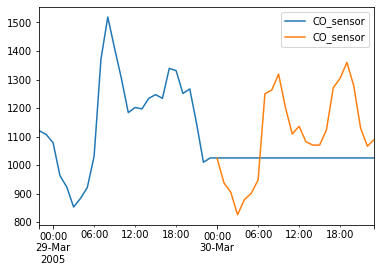

rmse:  170.41958025219208


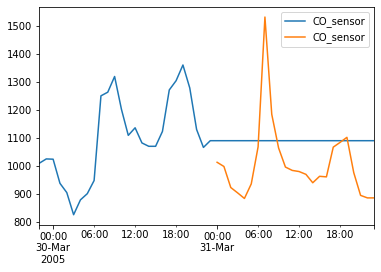

rmse:  156.03298262440114


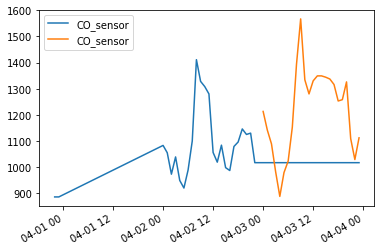

rmse:  254.51252424979012


In [27]:
# We loop, expanding the train set 24 hr.
# on each round.

# To collect the RMSE for each
# test set portion examined.
rmse_ls = []

for date in pd.date_range(start=start, end=end, freq="24H"):

    # Split the data:
    # Here we perform the expanding window.
    X_train = data[data.index < date]

    # We only select the next 24 hrs of real
    # Pollutant concentration.
    X_test = data[data.index >= date].head(24)

    # Multi-step forecast:
    for i in range(24):

        # make predictions on the train set
        preds = naive.predict(X_train)

        # Capture first prediction in a mini df.
        step = {"CO_sensor": [preds.iloc[-1]]}
        step = pd.DataFrame(step)

        # Append the correct timestamp to the prediction
        step.index = [X_train.iloc[-1].name + pd.offsets.Hour(1)]

        # Append the last prediction to the train
        # set.
        X_train = X_train.append(
            step, ignore_index=False, verify_integrity=True, sort=True
        )

    # Now, we check that the test set is aligned with
    # the 24 hr predictions.
    if preds.index.max() == X_test.index.max():

        # Plot the predictions for every 24hs chunk
        tmp = pd.concat([X_train.tail(50), X_test], axis=1)
        tmp["CO_sensor"].plot()
        plt.show()

        # We determine the RMSE.
        rmse_ = mean_squared_error(
            X_test["CO_sensor"],
            X_train["CO_sensor"].tail(24),
            squared=False,
        )
        print("rmse: ", rmse_)

        # Append the RMSE to our list
        rmse_ls.append(rmse_)

Now we've got predictions only for those days when we do have 24 hours of real pollutant concentration to be able to compare our forecasts.

To wrap-up, we determine the mean RMSE for every day in the test set that we examined.

In [28]:
# Mean performance during cross-validation

print("rmse: ", np.mean(rmse_ls), "+-", np.std(rmse_ls))
print("Number of days evaluated: ", len(rmse_ls))

rmse:  190.6728547803064 +- 51.50548061382903
Number of days evaluated:  20


That is all for this notebook. 

In the next one, we will expand this procedure to a linear regression.